In [1]:
# Retrieving contact maps from PINDER

from pathlib import Path
from torch.utils.data import DataLoader
from pinder.core import PinderLoader
from pinder.core.index.system import PinderSystem
from pinder.core.loader import structure
from pinder.core import get_pinder_location
from torch_geometric.nn import radius as georadius
from tqdm import tqdm
from pinder.core.loader import filters
from biotite.structure import sasa, apply_residue_wise
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
import os
import random
import pandas as pd
import torch
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.stats import pearsonr

PINDER_BASE_DIR="/scicore/home/schwede/durair0000/.local/share/"
SPLITS_DIR="/scicore/home/schwede/pudziu0000/projects/gLM/data/PINDER/eubacteria_5_1024_512_species/"
os.environ["PINDER_BASE_DIR"] = PINDER_BASE_DIR
get_pinder_location()

def get_data(
    system_id,
    interface_threshold=8.0,
):
    system = PinderSystem(system_id)
    if system is None:
        return None
    seq_r, seq_l = system.native_R.sequence, system.native_L.sequence
    try:
        sasa_r = apply_residue_wise(
            system.native_R.atom_array, sasa(system.native_R.atom_array), np.nansum
        )
        sasa_l = apply_residue_wise(
            system.native_L.atom_array, sasa(system.native_L.atom_array), np.nansum
        )
    except Exception as e:
        print(e)
        return None
    r_coords = system.native_R.filter("atom_name", mask=["CA"]).coords
    l_coords = system.native_L.filter("atom_name", mask=["CA"]).coords
    if r_coords.shape[0] == len(seq_r) and l_coords.shape[0] == len(seq_l):
        pos_l, pos_r = georadius(
            torch.tensor(r_coords),
            torch.tensor(l_coords),
            r=interface_threshold,
            max_num_neighbors=10000,
        )
        return {
            "id": system_id,
            "pos_r": pos_r,
            "pos_l": pos_l,
            "seq_r": seq_r,
            "seq_l": seq_l,
            "sasa_r": sasa_r,
            "sasa_l": sasa_l,
        }
    return None

def get_atom_data(split, interface_threshold=8.0):
    # Retrieving positions of the residues that are considered to be interacting with each other
    df = pd.read_csv(f"{SPLITS_DIR}/{split}.txt", sep="\t")
    
    ids = {"R": [], "L": []}
    for i, j in df.iterrows():
        # Neglecting negatives
        if(df["label"][i] == 0): continue
        idR = df["protein1"][i]
        idL = df["protein2"][i]
        ids["R"].append(idR)
        ids["L"].append(idL)

    atom_data = []
    
    for i, id_ in enumerate(ids["R"]):
        try:
            struct_r = structure.Structure(f"{PINDER_BASE_DIR}/pinder/2024-02/pdbs/{id_}-R.pdb", pinder_id=id_)
            struct_l = structure.Structure(f"{PINDER_BASE_DIR}/pinder/2024-02/pdbs/{ids['L'][i]}-L.pdb", pinder_id=ids['L'][i])
        except Exception as e:
            print(e)
            continue
        sasa_r = apply_residue_wise(
            struct_r.atom_array, sasa(struct_r.atom_array), np.nansum
        )
        sasa_l = apply_residue_wise(
            struct_l.atom_array, sasa(struct_l.atom_array), np.nansum
        )
        r_coords = struct_r.filter("atom_name", mask=["CA"]).coords
        l_coords = struct_l.filter("atom_name", mask=["CA"]).coords

        dist_m = torch.cdist(torch.tensor(r_coords), torch.tensor(l_coords))

        pos_l, pos_r = georadius(
            torch.tensor(r_coords),
            torch.tensor(l_coords),
            r=interface_threshold,
            max_num_neighbors=10000,
        )

        pos_dists = []
        for j in range(len(pos_r)):
            pos_dists.append(dist_m[pos_r[j]][pos_l[j]].item())
        
        atom_data_el = {
            "id": f"{id_}-{ids['L'][i]}",
            "pos_r": pos_r,
            "pos_l": pos_l,
            "sasa_r": sasa_r,
            "sasa_l": sasa_l,
            "len_r": len(struct_r.sequence),
            "len_l": len(struct_l.sequence),
            "dist_matrix": dist_m,
            "pos_dists": pos_dists
        }
        
        atom_data.append(atom_data_el)

    return atom_data

def get_contact_map(data_dict, padding=None):
    contact_map = np.zeros((data_dict["len_r"], data_dict["len_l"]))

    for i in range(len(data_dict["pos_r"])):
        contact_map[data_dict["pos_r"][i].item()][data_dict["pos_l"][i].item()] = 1

    if(padding):
        contact_map = contact_map[padding:-padding, padding:-padding]
    return contact_map

def get_cj_map(data_dict, cj_path, n, padding=None):
    id_for_file = data_dict["id"].translate(str.maketrans({'_': '-', '-': '_'}))
    cj = np.load(f"{cj_path}/{id_for_file}_fastCJ.npy")
    # Setting the threshold for the outlier count
    m = np.mean(cj)
    s = np.std(cj)
    threshold = m+n*s

    # Retrieving upper-right quadrant and skipping the tokens <+>
    upper_right_quadrant_cj = cj[1:data_dict["len_r"]+1, data_dict["len_r"]+2:]
    upper_right_quadrant_cm = np.where(upper_right_quadrant_cj > threshold, 1, 0)

    if(padding):
        upper_right_quadrant_cj = upper_right_quadrant_cj[padding:-padding, padding:-padding]
    return upper_right_quadrant_cm, upper_right_quadrant_cj

In [2]:
data = get_atom_data("test")

In [3]:
len(data)


332

In [4]:
# Loading the categorical Jacobian
CJ_PATH="/scicore/home/schwede/pudziu0000/projects/gLM/outputs/categorical_jacobians/glm2_cosine/"

mccs = []
precs = []
recs = []
bal_accs = []
tnrs = []

perc_cj_bits_in_cm_arr = []

dist_corr = []
neg_dists = []
pos_dists = []

for i in range(len(data)):
    contact_map = get_contact_map(data[i], padding=None)
    cj_contact_map, cj = get_cj_map(data[i], CJ_PATH, n=3, padding=None)
    
    # Compute the correlation between the quadrants
    mcc = matthews_corrcoef(contact_map.flatten(), cj_contact_map.flatten())
    prec = precision_score(contact_map.flatten(), cj_contact_map.flatten())
    rec = recall_score(contact_map.flatten(), cj_contact_map.flatten())
    bal_acc = balanced_accuracy_score(contact_map.flatten(), cj_contact_map.flatten())
    tn, fp, fn, tp = confusion_matrix(contact_map.flatten(), cj_contact_map.flatten()).ravel()
    tnr = tn/(tn+fp)
    mccs.append(mcc)
    precs.append(prec)
    recs.append(rec)
    bal_accs.append(bal_acc)
    tnrs.append(tnr)

    # Computing the percentage of cj_cm signals in true_cm
    cj_bits_in_cm = np.where(cj_contact_map == 1, contact_map, 0)
    if(np.sum(cj_contact_map)):
        perc_cj_bits_in_cm = cj_bits_in_cm.sum()/np.sum(cj_contact_map)
    else:
        perc_cj_bits_in_cm = 0
    perc_cj_bits_in_cm_arr.append(perc_cj_bits_in_cm)

    # Computing correlation between distances and cj signals
    dist_corr.append(np.corrcoef(np.array(data[i]["dist_matrix"].flatten()), cj.flatten())[0][1])

    # Collecting info for plotting the distribution of distances
    bool_pos_mask = cj_contact_map.astype(bool)
    bool_neg_mask = (1-cj_contact_map).astype(bool)
    
    pos_dist = data[i]["dist_matrix"][bool_pos_mask]
    neg_dist = np.array(data[i]["dist_matrix"][bool_neg_mask])
    
    neg_dist_downsampled = random.sample(sorted(neg_dist), len(pos_dist))

    pos_dists += pos_dist
    neg_dists += neg_dist_downsampled

/scratch/pudziu0000/slurm-job.41632402/ipykernel_2976023/3290091682.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  dist_corr.append(np.corrcoef(np.array(data[i]["dist_matrix"].flatten()), cj.flatten())[0][1])
/scratch/pudziu0000/slurm-job.41632402/ipykernel_2976023/3290091682.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  neg_dist = np.array(data[i]["dist_matrix"][bool_neg_mask])
/scratch/pudziu0000/slurm-job.41632402/ipykernel_2976023/3290091682.py:42: Deprecat

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 9900 and the array at index 1 has size 10000

In [5]:
print("MCC: ", np.average(mccs))

# Ability not to label a negative sample as a positive
print("Precision: ", np.average(precs))

# Ability to find all positive samples 
print("Recall: ", np.average(recs))

# Ability to find all negative samples
print("Specificity: ", np.average(tnrs))

# Being right overall
print("Balanced accuracy: ", np.average(bal_accs))

# How many matches of outliers in the contact map signal
print("Average percentage of outliers within contact map: ", np.average(perc_cj_bits_in_cm_arr))

# Correlation coefficient between real distances and CJ signals
print("Correlation between distances and CJ: ", np.average(dist_corr))


MCC:  0.017462850955104574
Precision:  0.01891936642708193
Recall:  0.02407872520057646
Specificity:  0.997789370828155
Balanced accuracy:  0.5109340480143657
Average percentage of outliers within contact map:  0.01891936642708193
Correlation between distances and CJ:  0.001293109597849026


In [6]:
dist_corr = np.array(dist_corr)

print("Average corr. coeff. for negative corr. coeff: ", np.average(dist_corr[np.where(dist_corr < 0)]))
print("Average corr. coeff. for positive corr. coeff: ", np.average(dist_corr[np.where(dist_corr >= 0)]))


Average corr. coeff. for negative corr. coeff:  -0.017629402858164948
Average corr. coeff. for positive corr. coeff:  0.015131961991053273


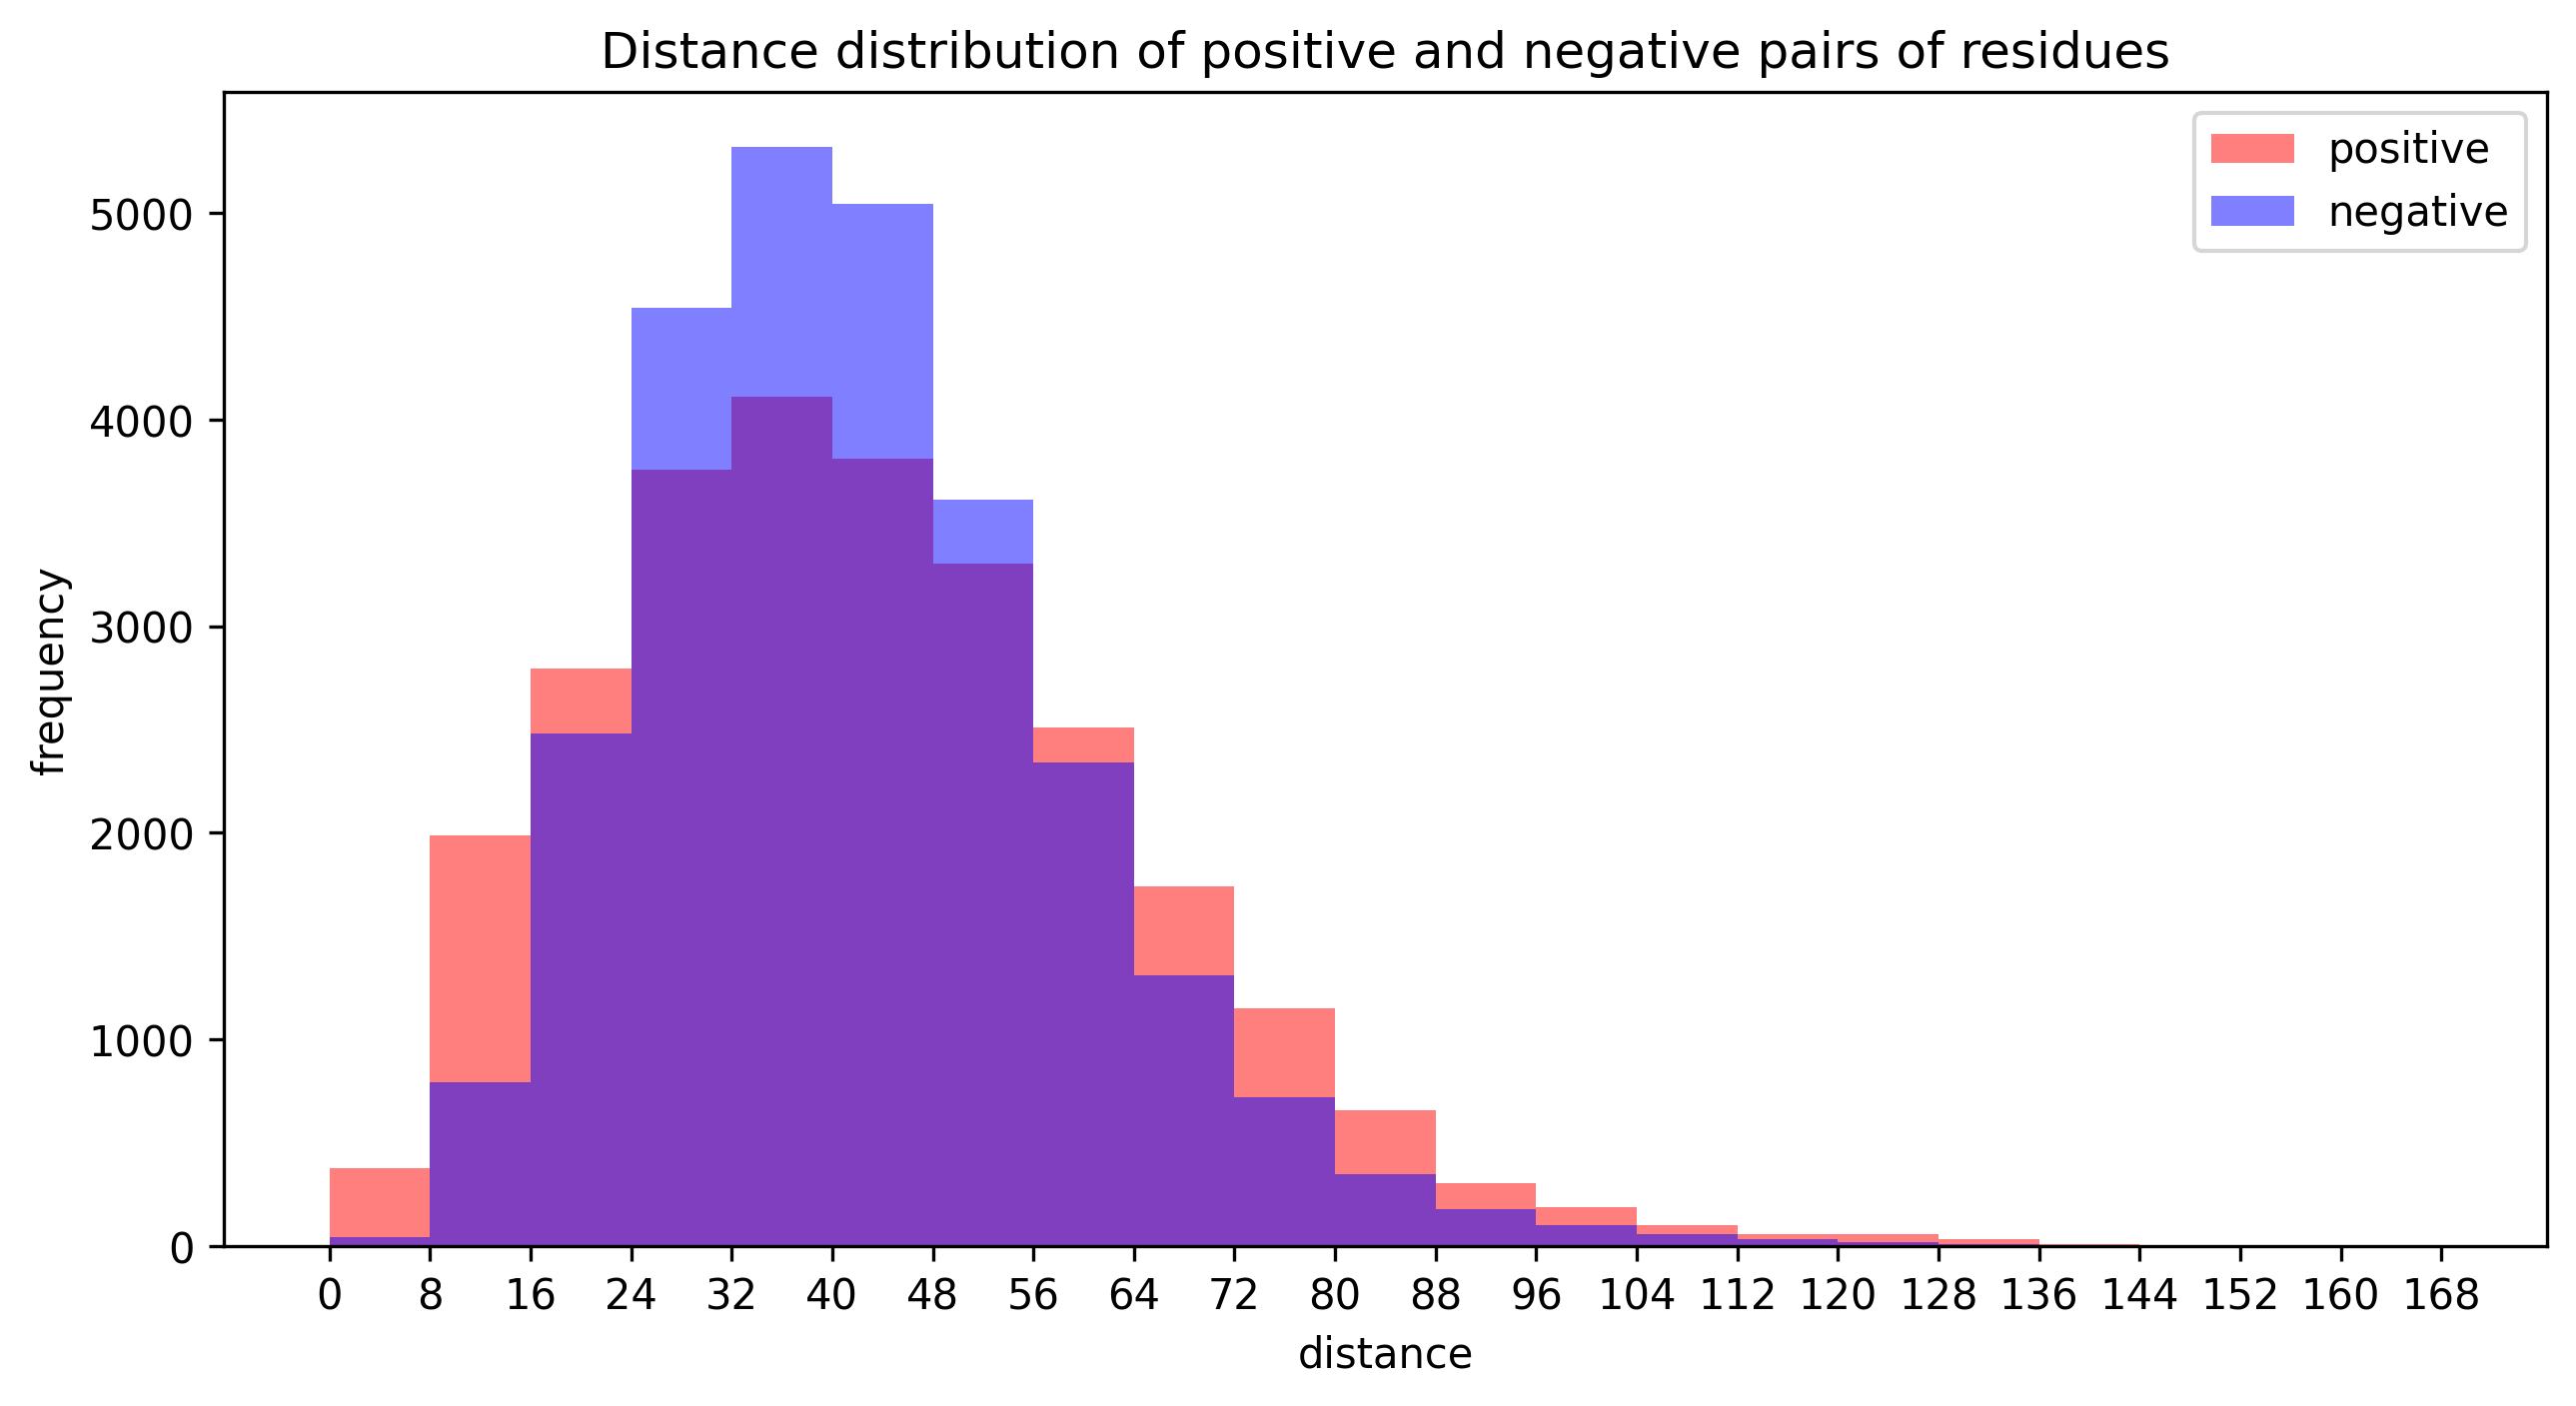

In [26]:
import matplotlib
import matplotlib.pyplot as plt

# Plotting distribution of distances for positive and negative pairs of residues.
# Positivity / negativity is determined based on the signals in categorical Jacobian.
# If the signal is considered as an outlier, it indicated the "positive" pair.

matplotlib.rcParams['figure.dpi'] = 300
plt.figure(figsize=(10, 5))

plt.hist(pos_dists, bins=range(0, round(max(pos_dists).item())+8, 8),
         color='red', alpha=0.5, label='positive'
)
plt.hist(neg_dists, bins=range(0, round(max(pos_dists).item())+8, 8),
         color='blue', alpha=0.5, label='negative'
)
plt.xlabel('distance')
plt.ylabel('frequency')
plt.title('Distance distribution of positive and negative pairs of residues')
plt.legend()

plt.xticks(range(0, round(max(pos_dists).item())+8, 8))
plt.show()